In [2]:
from pykeen.datasets import get_dataset
import torch
import matplotlib.pyplot as plt

In [56]:
kg = "FB15k-237"

colors = ['#003560', '#8DAE10', '#ac329d']

### Descriptive statistics over chosen knowledge graph

In [57]:
dataset = get_dataset(dataset=kg)

training_triples = dataset.training.mapped_triples
validation_triples = dataset.validation.mapped_triples
testing_triples = dataset.testing.mapped_triples

In [47]:
def fill_up_counts(unique_output, length, fill_value):
    filled_up_list = [None] * length
    indices_greater_zero = set(unique_output[0].numpy())
    counts = list(unique_output[1].numpy())
    for i in range(length):
        if i in indices_greater_zero:
            filled_up_list[i] = counts.pop(0)
        else:
            filled_up_list[i] = fill_value
        
    return torch.tensor(filled_up_list)

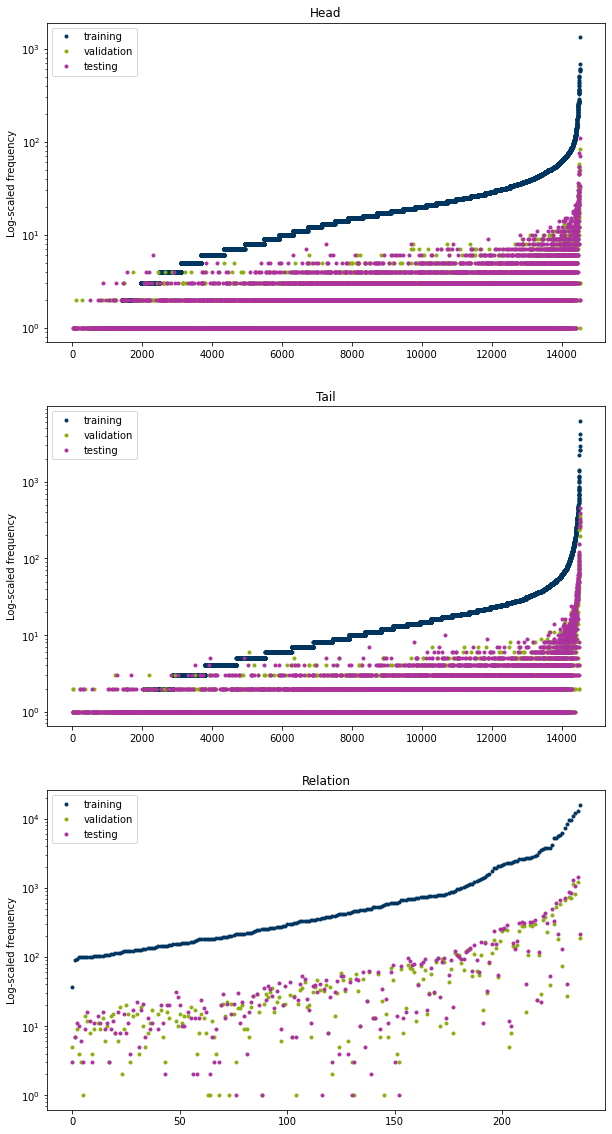

In [58]:
title = ["Head", "Relation", "Tail"]
lengths = [dataset.num_entities, dataset.num_relations, dataset.num_entities]
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,20))

for i, ax in zip([0,2,1], [ax1,ax2,ax3]):

    training_frequencies = fill_up_counts(training_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], 0)
    sorted_training_frequencies = training_frequencies.sort()
    
    validation_frequencies = fill_up_counts(validation_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], float('nan'))
    sorted_validation_frequencies = validation_frequencies.index_select(dim=0, index=sorted_training_frequencies.indices)
    testing_frequencies = fill_up_counts(testing_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], float('nan'))
    sorted_testing_frequencies = testing_frequencies.index_select(dim=0, index=sorted_training_frequencies.indices)

    linestyle=""
    if lengths[i] > 100:
        marker="."
    else:
        #linestyle="-"
        marker="o"
    ax.plot(range(lengths[i]), sorted_training_frequencies.values, label="training", color=colors[0], marker=marker, linestyle=linestyle)
    ax.plot(range(lengths[i]), sorted_validation_frequencies, label="validation", color=colors[1], marker=marker, linestyle=linestyle)
    ax.plot(range(lengths[i]), sorted_testing_frequencies, label="testing", color=colors[2], marker=marker, linestyle=linestyle)

    ax.legend()
    ax.set_yscale('log')
    ax.set_title(title[i])
    ax.set_ylabel("Log-scaled frequency")

    

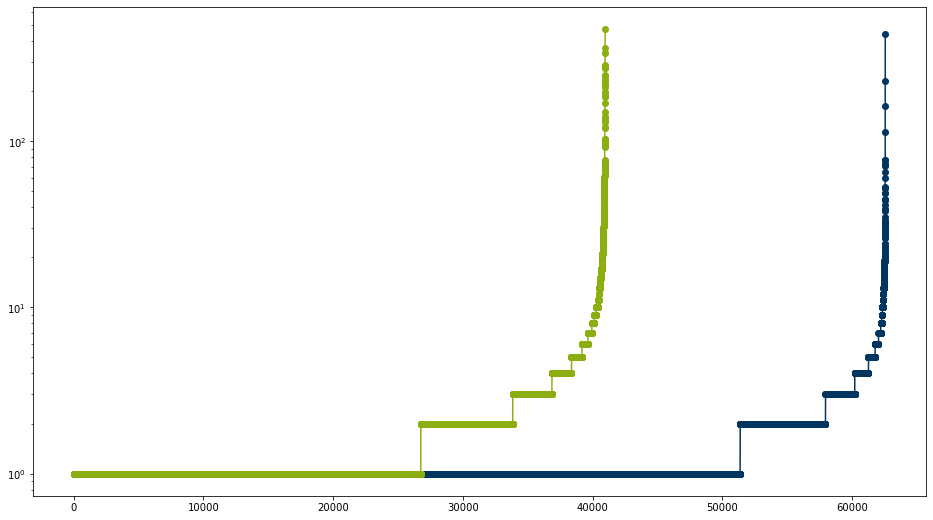

In [41]:
plt.figure(figsize=(16,9))
triple_frequencies = training_triples.index_select(dim=1, index=torch.tensor([0,1])).unique(return_counts=True, dim=0)
sorted_triple_frequencies = triple_frequencies[1].sort()

plt.yscale('log')
plt.plot(range(len(sorted_triple_frequencies.values)), sorted_triple_frequencies.values, label="training", color=colors[0], marker=marker, linestyle=linestyle)

triple_frequencies = training_triples.index_select(dim=1, index=torch.tensor([1,2])).unique(return_counts=True, dim=0)
sorted_triple_frequencies = triple_frequencies[1].sort()

plt.yscale('log')
plt.plot(range(len(sorted_triple_frequencies.values)), sorted_triple_frequencies.values, label="training", color=colors[1], marker=marker, linestyle=linestyle)


### Size of EII (standard vs. relaxed ESNS)

### Statistics over RBM outputs